# Ejercicio 1

### Introduccion

El dataset que subimos consiste en un diccionario que consta de tres elementos:

`tiempos_disparos` es una lista de 1000 elementos. Cada elemento corresponde a los tiempos de disparo de una neurona (unidades en $s$).

`velocidades` es un vector con valores de velocidad en el tiempo (unidades en $m/s$).

`tiempos_velocidades` es un vector de tiempos correspondiente a cada valor de velocidad (unidades en $s$).

El dataset fue simulado generando un vector de velocidad de forma aleatoria (de tipo *random walk* gaussiano) y trenes de disparos independientes provenientes de un proceso de Poisson no estacionario (para quienes le interese, ya lo vamos a ver pero [aca](https://elephant.readthedocs.io/en/latest/index.html) pueden aprender de una libreria muy piola para hacerlo). Esto ultimo quiere decir que generamos disparos de neuronas independientes mediante distribuciones de Poisson cuyas medias de disparo $\lambda$ variaban en el tiempo en funcion de la velocidad $v$ siguiendo un modelo mas o menos como este



$$\lambda_i(v) = r_i + \alpha_i\left[v-v_{i}^{th}\right]^+ $$

donde la operacion $[\alpha]^+=\alpha$ si $\alpha>0$ y $[\alpha]^+=0$ si $\alpha<0$. Lo importante es que es un modelo de respuesta lineal a la velocidad, algo relativamente verosimil a lo que se ve en varios tipos de neuronas que codifican velocidad en distintas partes del cerebro (aunque bastante muy de juguete).

La idea de este ejercicio es que sea bastante guiado para que tengan un primer appoach algo metodico para ver y aplicar PCA, pero la posta va a estar en el ejercicio 2.

### Importamos librerias utiles (pueden usar las que quieran)

In [2]:
import numpy as np
import matplotlib.pylab as plt

#### Primero, descarguen la data y carguenla en el notebook.

In [3]:
import pickle
mypath = "/home/gmartone/Desktop/ITBA/Neuro/Ej1/" #aca pongan la direccion del archivo

with open(mypath+'DataTP1.pkl', 'rb') as fp:
    data = pickle.load(fp)

tiempos_disparos = data['tiempos_disparos']
tiempos_velocidades = data['tiempos_velocidades']
velocidades = data['velocidades']

## Inciso (a)

- Realizar un rasterplot de los trenes de disparo en el tiempo
- Visualizar velocidad vs. tiempo

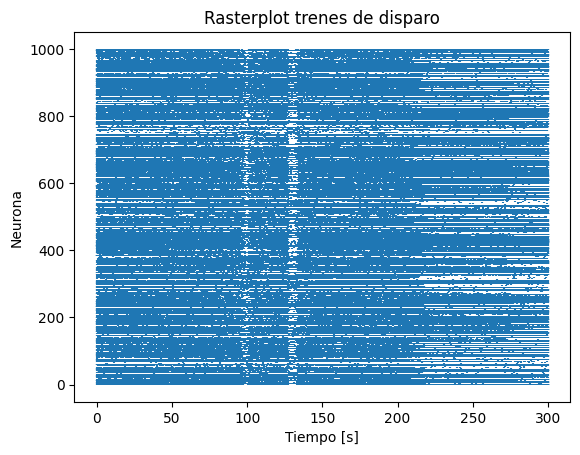

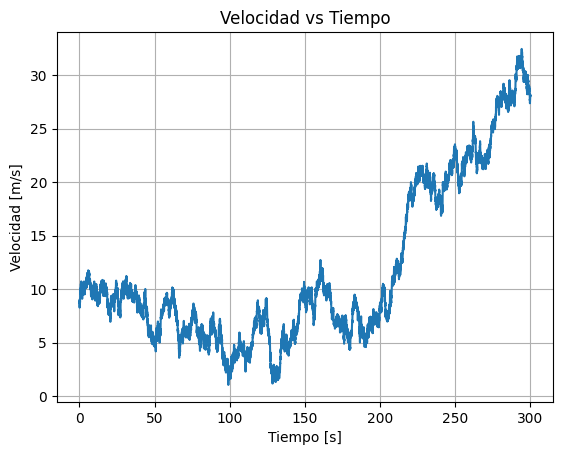

In [40]:
plt.xlabel("Tiempo [s]")
plt.ylabel("Neurona")
plt.title("Rasterplot trenes de disparo")
plt.eventplot(tiempos_disparos)
plt.show()

plt.title("Velocidad vs Tiempo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Velocidad [m/s]")
plt.plot(tiempos_velocidades, velocidades)
plt.grid(True)
plt.show()

## Inciso (b)

Pasar los disparos a tasas de disparo realizando un promedio móvil con una ventana temporal adecuada



In [6]:
#@title Hint

#La idea aca es que bineen la data y sumen la cantidad de disparos por cada bin
#temporal (y lo mismo con el vector de velocidades). Hay muchas formas de hacer-
#lo, aca les dejamos una

#(1) Definan un bin temporal que les parezca razonable. La data esta en segundos,
#asi que una forma de estimar el sampling rate de los datos es calculando la
#media de la diferencia entre tiempos de mediciones consecutivas
dt = np.mean(np.diff(tiempos_velocidades))

N = len(tiempos_disparos) #numero de neuronas

#dado que el dt es de 10ms, promediar de a un segundo nos garantiza juntar varios
#disparos por bin
ancho_bin = 1

#Como los tiempos de las velocidades estan equiespaciados, los sampleamos con el
#ancho elegido
bin_tiempos_velocidades = tiempos_velocidades[::int(ancho_bin/dt)]
bin_velocidades = [np.mean(velocidades[i*int(ancho_bin/dt):(i+1)*int(ancho_bin/dt)]) for i in range(len(bin_tiempos_velocidades)-1)] #velocidad media por bin

#Calculamos y almacenamos las tasas de disparo en una matriz
tasa_disparo = np.zeros((N,len(bin_tiempos_velocidades)-1))
for n in range(tasa_disparo.shape[0]):
  tasa_disparo[n,:], _ = np.histogram(tiempos_disparos[n], bins=bin_tiempos_velocidades)

### Inciso (c)

Usando los datos del punto (b), visualizar la respuesta de las neuronas a las distintas velocidades ¿Todas responden de la misma forma?

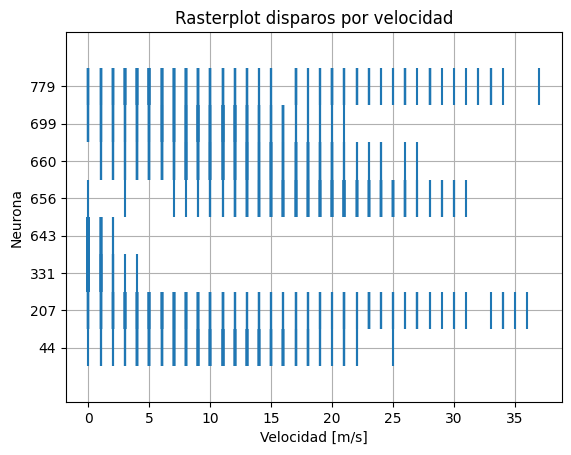

In [35]:
indices_de_neuronas = [44, 207, 331, 643, 656, 660, 699, 779]
valores = [tasa_disparo[i] for i in indices_de_neuronas]
plt.eventplot(valores)
plt.yticks(range(0, len(valores)), indices_de_neuronas)
plt.xlabel("Velocidad [m/s]")
plt.ylabel("Neurona")
plt.title("Rasterplot disparos por velocidad")
plt.grid(True)
plt.show()

### Inciso (d)

Aplicar PCA sobre los datos del punto b y graficar la varianza explicada cumulativa ¿Cuántas dimensiones esperas que sean necesarias para capturar la dinámica relevante del problema?


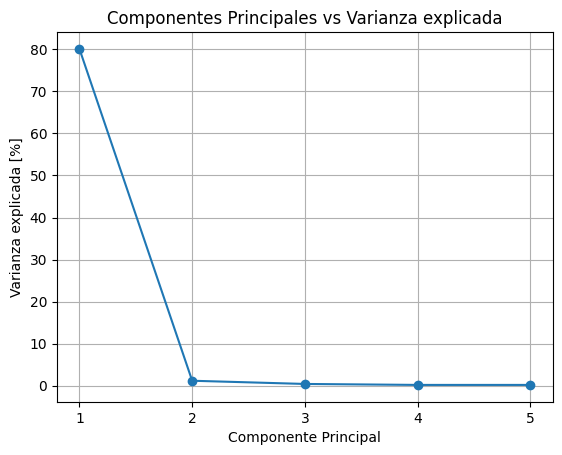

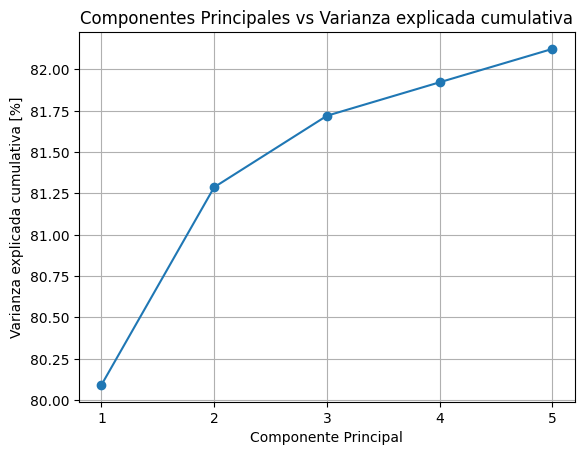

In [37]:
from sklearn.decomposition import PCA

pca = PCA(5)
transposed_tasa_disparo = tasa_disparo.transpose()
pca_results = pca.fit_transform(transposed_tasa_disparo)

# Explained variance vs Principal component
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance*100, marker='o')
plt.xticks(range(1, len(explained_variance) +1))
plt.xlabel("Componente Principal")
plt.ylabel("Varianza explicada [%]")
plt.title("Componentes Principales vs Varianza explicada")
plt.grid(True)
plt.show()

cumulative_variance = np.zeros(explained_variance.shape)
for i in range(len(explained_variance)):
    for j in range(0, i+1):
        cumulative_variance[i] += explained_variance[j]

# Cumulative variance vs Principal component
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance*100, marker='o')
plt.xticks(range(1, len(cumulative_variance) +1))
plt.xlabel("Componente Principal")
plt.ylabel("Varianza explicada cumulativa [%]")
plt.title("Componentes Principales vs Varianza explicada cumulativa")
plt.grid(True)
plt.show()

### Inciso (e)

Visualizar en 2D
 - PC1 vs. PC2
 - PC1 vs. Velocidad
 - PC1 vs. tiempo

¿Tiene sentido en base a lo esperado?

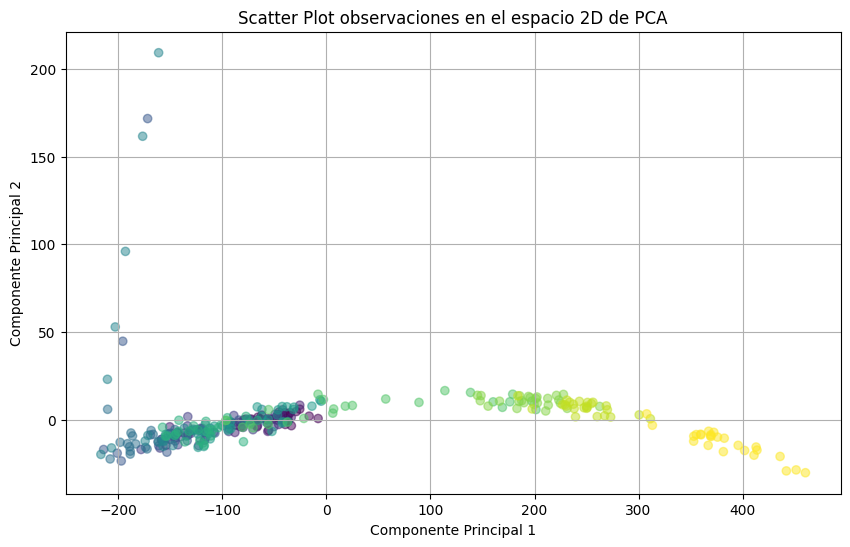

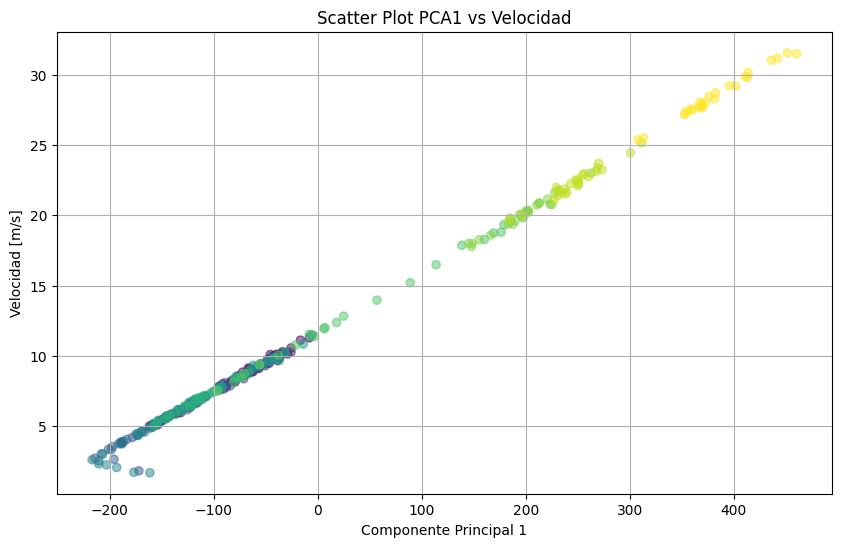

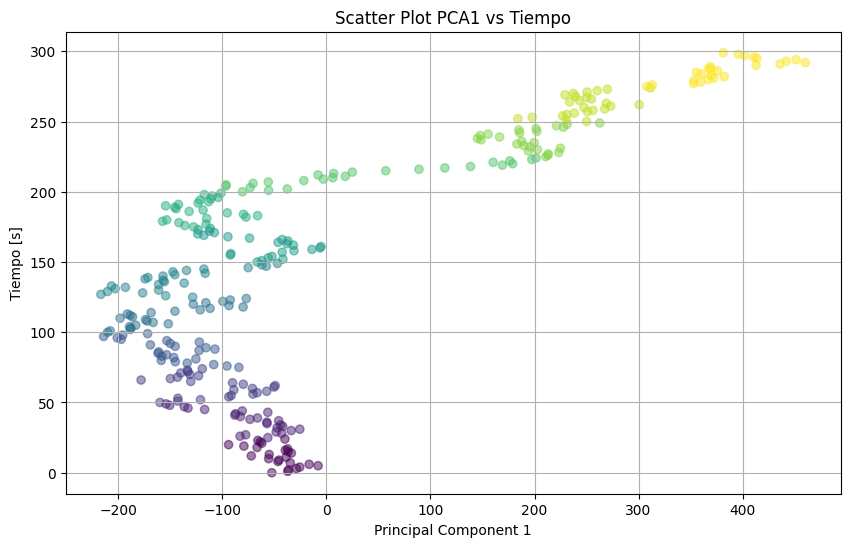

In [39]:
colores = [(i // 25) + 1 for i in range(len(pca_results))]
# PC1 vs. PC2
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0],  # PCA1
            pca_results[:, 1],  # PCA2 
            alpha=0.5,          # Transparencia 
            c=colores)          # asignacion de colores

plt.title('Scatter Plot observaciones en el espacio 2D de PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

# PC1 vs. Velocidad
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0],  # PCA1
            bin_velocidades,    # Velocidades 
            alpha=0.5,          # Transparencia 
            c=colores)          # asignacion de colores

plt.title('Scatter Plot PCA1 vs Velocidad')
plt.xlabel('Componente Principal 1')
plt.ylabel('Velocidad [m/s]')
plt.grid(True)
plt.show()

# PC1 vs. Tiempo
plt.figure(figsize=(10, 6))
plt.scatter(
    pca_results[:, 0],  # PCA1
    bin_tiempos_velocidades[0:300],    # Tiempo (son 301, me quedo con 300) 
    alpha=0.5,          # Transparencia 
    c=colores           # asignacion de colores
)          

plt.title('Scatter Plot PCA1 vs Tiempo')
plt.xlabel('Principal Component 1')
plt.ylabel('Tiempo [s]')
plt.grid(True)
plt.show()